# Variational Non-linear LFM

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`

In [56]:
import torch
from matplotlib.ticker import FormatStrFormatter
from torch.nn import Parameter
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.optim import NGD
from torch.optim import Adam
from lafomo.models import OrdinaryLFM, generate_multioutput_rbf_gp
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.torch import softplus
from lafomo.utilities.data import hafner_ground_truth
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import HafnerData
from lafomo.plot import Plotter, Colours

from matplotlib import pyplot as plt

import numpy as np

13


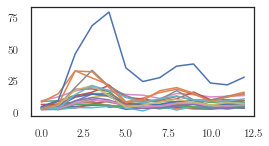

In [2]:
dataset = HafnerData(replicate=0, data_dir='../../../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]
print(num_times)

t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64)
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(-2, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

In [3]:
from gpytorch.constraints import Positive, Interval

class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        # self.decay_constraint = Interval(0, 1)
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(8 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return softplus(f).repeat(1, self.num_outputs, 1)

    def predict_f(self, t_predict):
        # Sample from the latent distribution
        q_f = super().predict_f(t_predict)
        f = q_f.sample(torch.Size([500])).permute(0, 2, 1)  # (S, I, T)
        print(f.shape)
        # This is a hack to wrap the latent function with the nonlinearity. Note we use the same variance.
        f = torch.mean(self.G(f), dim=0)[0].unsqueeze(0)
        print(f.shape, q_f.mean.shape, q_f.scale_tril.shape)
        batch_mvn = MultivariateNormal(f, q_f.covariance_matrix.unsqueeze(0))
        print(batch_mvn)
        return MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

class ExpTranscriptionLFM(TranscriptionLFM):

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        return torch.exp(f).repeat(1, self.num_outputs, 1)

In [4]:
config = VariationalConfiguration(
    num_samples=70,
    initial_conditions=False # TODO
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = False
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, zero_mean=False, initial_lengthscale=2, gp_kwargs=dict(natural=use_natural))
lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]

class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(4.2)
            dec = torch.tensor(0.21)
            self.lfm.raw_sensitivity[6] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[6] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

trainer = VariationalTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

(22,)
torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


Text(0.5, 1.0, 'Latent')

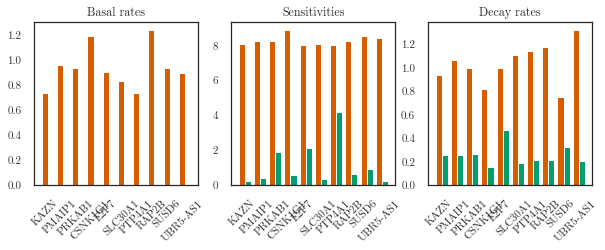

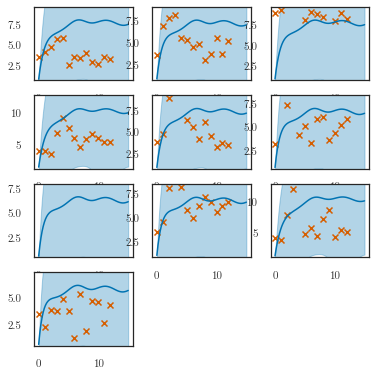

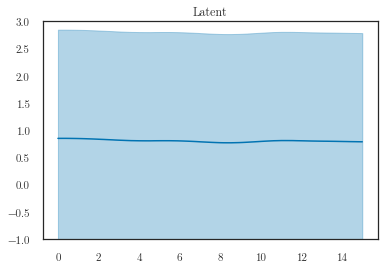

In [5]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
kinetics = list()
for i, key in enumerate(keys):
    kinetics.append(
        constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

print(kinetics[0].shape)
plotter.plot_double_bar(kinetics, labels, figsize=(10, 3), ground_truths=hafner_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [36]:
lfm.train()
# trainer = Trainer(optimizer)
output = trainer.train(500, step_size=5e-1, report_interval=10)

Epoch 501/1000 - Loss: 45.61 (43.56 2.04) kernel: [[[1.0944356]]]
Epoch 511/1000 - Loss: 45.48 (43.43 2.04) kernel: [[[1.0984298]]]
Epoch 521/1000 - Loss: 45.25 (43.20 2.05) kernel: [[[1.0931145]]]
Epoch 531/1000 - Loss: 45.12 (43.06 2.06) kernel: [[[1.0856982]]]
Epoch 541/1000 - Loss: 45.00 (42.93 2.07) kernel: [[[1.0855027]]]
Epoch 551/1000 - Loss: 44.82 (42.74 2.08) kernel: [[[1.0807883]]]
Epoch 561/1000 - Loss: 44.63 (42.56 2.07) kernel: [[[1.0730261]]]
Epoch 571/1000 - Loss: 44.51 (42.42 2.10) kernel: [[[1.0726347]]]
Epoch 581/1000 - Loss: 44.33 (42.23 2.10) kernel: [[[1.0754915]]]
Epoch 591/1000 - Loss: 44.14 (42.05 2.09) kernel: [[[1.0708594]]]
Epoch 601/1000 - Loss: 44.09 (41.98 2.11) kernel: [[[1.0661199]]]
Epoch 611/1000 - Loss: 43.85 (41.74 2.11) kernel: [[[1.0607657]]]
Epoch 621/1000 - Loss: 43.78 (41.66 2.11) kernel: [[[1.0548112]]]
Epoch 631/1000 - Loss: 43.64 (41.52 2.12) kernel: [[[1.0519868]]]
Epoch 641/1000 - Loss: 43.58 (41.45 2.12) kernel: [[[1.0432448]]]
Epoch 651/

### Outputs after training

torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


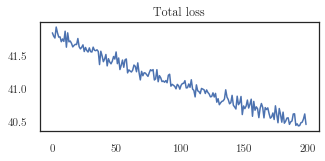

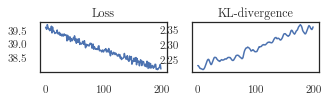

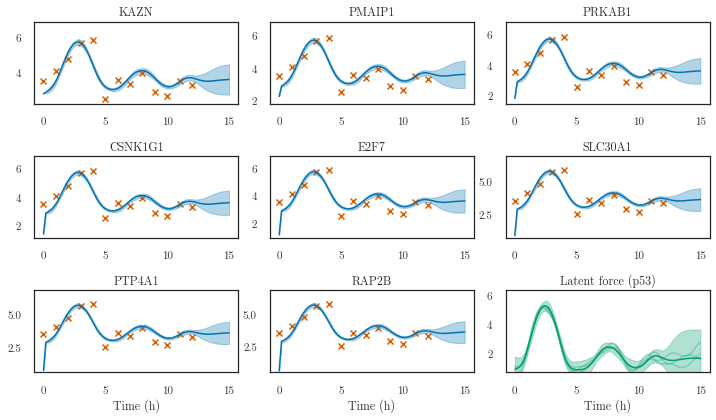

In [37]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_losses(trainer, last_x=200)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))

row = col = 0
for i in range(8):
    if i == (row+1) * 3:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,# ylim=(-2, 25.2),
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
    col += 1
    ax.set_title(dataset.gene_names[i])
plotter.plot_gp(q_f, t_predict, ax=axes[nrows-1, ncols-1],
                # ylim=(-1, 5),
                transform=softplus,
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[nrows-1, ncols-1].set_title('Latent force (p53)')
for col in range(ncols):
    axes[nrows-1, col].set_xlabel('Time (h)')

plt.tight_layout()
plt.savefig('./hafner-combined.pdf', **tight_kwargs)

torch.Size([500, 1, 80])
torch.Size([1, 80]) torch.Size([80, 1]) torch.Size([80, 80])
MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))


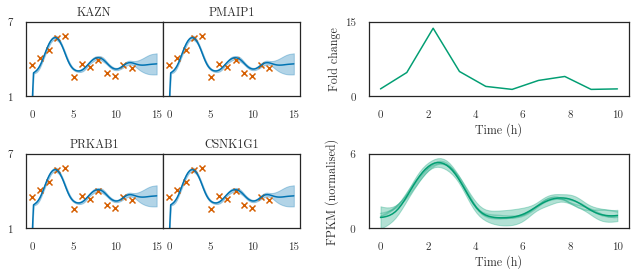

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 4),
                         gridspec_kw=dict(width_ratios=[1, 1, 0.5, 1.9], wspace=0))
row = col = 0
for i in range(4):
    if i == (row+1) * 2:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,# ylim=(-2, 25.2),
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed, num_samples=0)
    ax.set_title(dataset.gene_names[i])
    ax.set_ylim(1.0, 7.0)
    ax.set_yticks([1.0, 7.0])
    ax.figure.subplotpars.wspace = 0
    if col > 0:
        ax.set_yticks([])
    col += 1
y = [1.5, 4.8, 13.7, 5, 2, 1.4, 3.2, 4, 1.4, 1.5]
# y = y/np.mean(y)*np.mean(p) * 1.75-0.16
# y = scaler.fit_transform(np.expand_dims(y, 0))
axes[0, 3].plot(np.linspace(0, 10, len(y)), y, color=Colours.line2_color)
axes[0, 3].set_ylim(0, 15)
axes[0, 3].set_ylabel('Fold change')
axes[0, 3].set_xlabel('Time (h)')
axes[0, 3].set_yticks([0.0, 15.0])
t_temp = torch.linspace(0, 10, 80, dtype=torch.float32)
q_f = lfm.predict_f(t_temp)
plotter.plot_gp(q_f, t_temp, ax=axes[1, 3],
                transform=softplus,
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
axes[1, 3].set_yticks([0, 4])
axes[1, 3].set_xlabel('Time (h)')
axes[1, 3].set_ylabel('FPKM (normalised)')
axes[1, 3].set_yticks([0.0, 6.0])
axes[1, 3].set_ylim(0.0, 6)
axes[1, 3].yaxis.set_major_formatter(FormatStrFormatter('  %.0f'))
axes[1, 2].set_visible(False)
axes[0, 2].set_visible(False)

fig.tight_layout()

plt.savefig('./hafner-comparison.pdf', **tight_kwargs)

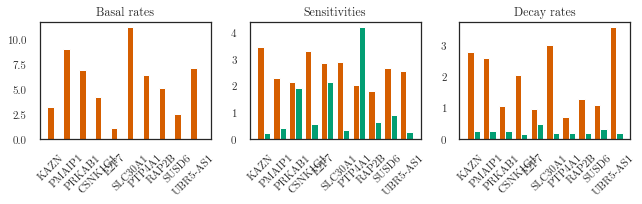

In [9]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
keys = ['raw_basal', 'raw_sensitivity', 'raw_decay']
constraints = [lfm.positivity, lfm.positivity, lfm.positivity]
kinetics = list()
for i, key in enumerate(keys):
    kinetics.append(
        constraints[i].transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels,
                        figsize=(9, 3),
                        ground_truths=hafner_ground_truth())
                        # yticks=[
                        #     np.linspace(0, 0.12, 5),
                        #     np.linspace(0, 1.2, 4),
                        #     np.arange(0, 1.1, 0.2),
                        # ])
plt.tight_layout()
# plt.savefig('./hafner-kinetics.pdf', **tight_kwargs)

# plotter.plot_convergence(trainer)

tensor([2.0337], dtype=torch.float64, grad_fn=<SelectBackward>)


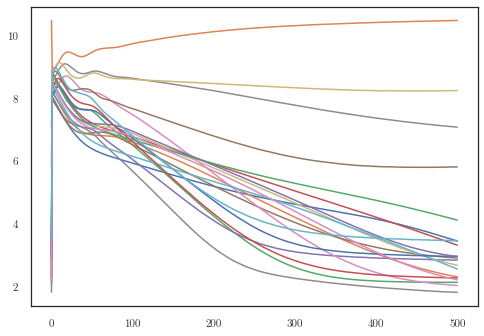

In [10]:
# print(lfm.decay_rate)
print(lfm.sensitivity[6])
for i in range(20):
    plt.plot(lfm.positivity.transform(torch.stack(trainer.parameter_trace['raw_sensitivity'])[:, i]))